<a href="https://colab.research.google.com/github/SergiiRv/AP_predict_LSTM/blob/main/Copy_of_GapFreeLSTM_Conv_v2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%%capture
! pip install torch pytorch-lightning
! pip install neptune-client==0.9.0 
! pip install pytorch-lightning-bolts


In [ ]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.metrics import ExplainedVariance
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.profiler import SimpleProfiler
 
from sklearn.model_selection import train_test_split
 
import numpy as np
import pandas as pd

import gc
import sys
 
import matplotlib as mpl
import matplotlib.pyplot as plt

from pytorch_lightning.loggers.neptune import NeptuneLogger
 
plt.ion()   # interactive mode

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/gdrive')
 
csvpath = '/content/gdrive/PUT_YOUR_FOLDER/finaldata.csv'  #change the folder with data file whereever it is located on your G-drive
#data_list = pd.read_csv(csvpath)
#print(scans_list.head(10), '\n', scans_list.tail(10))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#checking the avaliable GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

#checking the avaliable RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Fri Apr  9 22:08:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# MODEL input parameters
out_channels = 1 # PARAMS['out_channels'] Conv
kernel_size = 20 # PARAMS['kernel_size'] Conv
Stide_size = 10 # PARAMS['Stide_size'] Conv
 
input_size = 4 #*8 # PARAMS['input_size'] LSTM
hidden_size = 70 #*120 # PARAMS['hidden_size'] LSTM
num_layers = 2 #2* # PARAMS['num_layers'] LSTM
output_size = 1 # PARAMS['output_size'] Linear
 
batch_size=64 #*128 # PARAMS['batch_size']
learning_rate=0.005 # PARAMS['learning_rate']

lookback = 1011 # PARAMS['lookback']
lookforward = 50 #100 # PARAMS['lookforward']

m_max_epochs = 20 # PARAMS['m_max_epochs']

lastpath = "/content/gdrive/PUT_YOUR_FOLDER/Model_saved/last_v.ckpt"
fileout = "/content/gdrive/PUT_YOUR_FOLDER/Model_saved/test.out"

lastpathED = "/content/gdrive/PUT_YOUR_FOLDER/Model_saved/last_vED.ckpt"

settrainset = True

PARAMS = {'m_max_epochs': m_max_epochs,
          'lookforward': lookforward,
          'lookback': lookback,
          'learning_rate': learning_rate,
          'batch_size': batch_size,
          'out_channels': out_channels,
          'kernel_size': kernel_size,
          'Stide_size': Stide_size,
          'input_size': input_size,
          'hidden_size': hidden_size,
          'num_layers': num_layers,
          'output_size': output_size}

#run['parameters'] = PARAMS
#run = neptune.init(project='sergiirom/GapFreeLSTM')
loggerstr = ''.join(str(x) for x in [lookback, lookforward, hidden_size, num_layers])

In [ ]:


neptune_logger = NeptuneLogger(
    api_key="PUT_YOUR KEY",
    project_name='PUT_YOUR NAME',
    experiment_name='GapFreeConv_YOUR',
    tags=['WHATEVER YOU LIKE', loggerstr],
    params=PARAMS)


NeptuneLogger will work in online mode


In [ ]:
class GapFreeDataModule(pl.LightningDataModule):
 
  def __init__(self, batch_size, lookback, lookforward, data_file_path):
    super().__init__()
    self.data_file_path = data_file_path
    self.batch_size = batch_size
    self.lookback = lookback
    self.lookforward = lookforward

  def prepare_data(self):
    #load data
    alldata = np.array(pd.read_csv(self.data_file_path))
    X, Y=[],[]
    for i in range(np.int32(np.floor((len(alldata)-self.lookback)/self.lookforward/2))): #.astype(int)
      ii=i*self.lookforward+self.lookback
      X.append(alldata[ii-self.lookback:ii])
      Y.append(alldata[ii-self.lookback+self.lookforward:ii+self.lookforward])
    self.x = np.array(X)
    self.y = np.array(Y) #dims[chunks, [lookback, 1]]
    del X, Y
    torch.cuda.empty_cache()
    

  def setup(self, stage=None):
      x_train, x_val, y_train, y_val = train_test_split(self.x, self.y, test_size=0.15, shuffle = True)
      x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle = True)  

      # Assign train/val datasets for using in dataloaders
      if stage == 'fit' or stage is None:
        self.x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
        self.y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
        self.x_val = torch.from_numpy(x_val).type(torch.FloatTensor)
        self.y_val = torch.from_numpy(y_val).type(torch.FloatTensor)

      # Assign test dataset for using in dataloader(s)
      if stage == 'test' or stage is None:
        self.x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
        self.y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

      self.dims_train = self.x_train.shape
      self.dims_val = self.x_val.shape
      self.dims_test = self.x_test.shape
      
      #del x_train, x_val, y_train, y_val, x_train, x_test, y_train, y_test
      x_train = None 
      x_val= None 
      y_train= None 
      y_val= None 
      x_train= None 
      x_test= None 
      y_train= None 
      y_test= None
      torch.cuda.empty_cache()
      gc.collect()
      
  def train_dataloader(self):
      # Called when training the model
      self.train_dataset = torch.utils.data.TensorDataset(self.x_train, self.y_train)
      return DataLoader(self.train_dataset, batch_size=self.batch_size, drop_last = True)

  def val_dataloader(self):
      # Called when evaluating the model (for each "n" steps or "n" epochs)
      self.val_dataset = torch.utils.data.TensorDataset(self.x_val, self.y_val)
      return DataLoader(self.val_dataset, batch_size=self.batch_size, drop_last = True)

  def test_dataloader(self):
      # Called when testing the model by calling: Trainer.test()
      self.test_dataset = torch.utils.data.TensorDataset(self.x_test, self.y_test)
      return DataLoader(self.test_dataset, batch_size=self.batch_size, drop_last = True)


In [ ]:
# ************************Encoder Decoder classes********************

class Encoder(nn.Module):
    def __init__(self, in_channels = 1, param_init = True):
        super(Encoder, self).__init__()
        self.inchl = in_channels
        self.param_init = param_init
        # encoder layers
        self.enc1 = nn.Conv1d(self.inchl, 128, kernel_size=5, stride=2, padding=0)
        self.enc2 = nn.Conv1d(128, 32, kernel_size=4, stride=2, padding=0)
        self.enc3 = nn.Conv1d(32, 16, kernel_size=3, stride=2, padding=0)
        self.enc4 = nn.Conv1d(16, 8, kernel_size=3, stride=2, padding=0)
        self.enc5 = nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=0)
        self.BN1 = nn.BatchNorm1d(128)
        self.BN2 = nn.BatchNorm1d(32)
        self.BN3 = nn.BatchNorm1d(16)
        self.BN4 = nn.BatchNorm1d(8)
        self.BN5 = nn.BatchNorm1d(4)
        self.relu = nn.ReLU()

        self.initialize_weights()

    def initialize_weights(self):
      if self.param_init:
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.ConvTranspose1d):
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # encode
        # x = 1011
        x = self.relu(self.BN1(self.enc1(x)))
        # x = 504
        x = self.relu(self.BN2(self.enc2(x)))
        # x = 251
        x = self.relu(self.BN3(self.enc3(x)))
        # x = 125
        x = self.relu(self.BN4(self.enc4(x)))
        # x = 63
        x = self.relu(self.BN5(self.enc5(x)))
        # x = 60
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels = 1, param_init = True):
        super(Decoder, self).__init__()
        self.inchl = in_channels
        self.param_init = param_init

        self.relu = nn.ReLU()
        self.HardSigm = nn.Hardsigmoid()

        self.initialize_weights()

        # decoder layers
        self.dec1 = nn.ConvTranspose1d(4, 8, kernel_size=3, stride=1, padding=0)  
        self.dec2 = nn.ConvTranspose1d(8, 16, kernel_size=3, stride=2, padding=0)
        self.dec3 = nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=0)
        self.dec4 = nn.ConvTranspose1d(32, 64, kernel_size=4, stride=2, padding=0)
        self.dec5 = nn.ConvTranspose1d(64, 128, kernel_size=5, stride=2, padding=0)
        self.out = nn.Conv1d(128, self.inchl, kernel_size=1, stride=1, padding=0)

        self.BN1 = nn.BatchNorm1d(8)
        self.BN2 = nn.BatchNorm1d(16)
        self.BN3 = nn.BatchNorm1d(32)
        self.BN4 = nn.BatchNorm1d(64)
        self.BN5 = nn.BatchNorm1d(128)

        self.initialize_weights()

    def initialize_weights(self):
      if self.param_init:
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
            elif isinstance(m, nn.ConvTranspose1d):
                nn.init.kaiming_uniform_(m.weight)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # decode
        x = self.relu(self.BN1(self.dec1(x)))
        #print("decode1", x.shape)
        x = self.relu(self.BN2(self.dec2(x)))
        #print("decode2", x.shape)
        x = self.relu(self.BN3(self.dec3(x)))
        #print("decode3", x.shape)
        x = self.relu(self.BN4(self.dec4(x)))
        #print("decode4", x.shape)
        x = self.relu(self.BN5(self.dec5(x)))
        #print("decode5", x.shape)
        x = self.out(x)
        #print("self.out", x.shape)
        x = self.HardSigm(x)
        return x


#net = nn.Sequential(Encoder(), Dencoder())
#print(net)

In [ ]:
# ************************Encoder Decoder classes combo for Lightening ********************
class Encoder_Decoder(pl.LightningModule):
 
    def __init__(self, encoder, decoder, batch_size, learning_rate=0.001):
      super().__init__()

      # Hyperparameters
      self.learning_rate = learning_rate
      self.batch_size = batch_size

      # Log hyperparameters
      self.save_hyperparameters()

      # Built-in API for Variance
      self.train_ExplainedVariance = pl.metrics.ExplainedVariance()
      self.val_ExplainedVariance = pl.metrics.ExplainedVariance()
      self.test_ExplainedVariance = pl.metrics.ExplainedVariance()

      #*****************************Model**************************************
      self.Encoder = encoder
      self.Decoder = decoder
     # -------------------------------------------------------------------------            
    def forward(self, x): 

      x = self.Encoder(x.permute(0,2,1)) #input of shape (batch,seq_len,1)->permute->(batch, feature=1, seq_len=1011)->out (batch, feature=, seq_len=)
      x = self.Decoder(x)
      predictions = x.permute(0,2,1) # (batch,seq_len,1)
     
      
      return predictions
    # -------------------------------------------------------------------------
 
    def training_step(self, batch, batch_idx):
      x, _ = batch
      forecast = self.forward(x)
      

      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, x)
      # Calculates ExplainedVariance for current batch
      train_EV_batch = self.train_ExplainedVariance(forecast, x)
      # Save metrics for current batch
      self.log('train_EV_batch', train_EV_batch)
      self.log('train_loss_batch', loss)

      torch.cuda.empty_cache()

      return {'loss' : loss, 'forecast' : forecast, 'true' : x}
        
    def training_epoch_end(self, outputs):
      Train_ExplainedVariance = self.train_ExplainedVariance.compute()
      self.log('Train_EV_epoch', Train_ExplainedVariance, prog_bar=True)
      trainerED.save_checkpoint(lastpathED)
      gc.collect()

    # --------------------------------------------------------------------------
 
    def validation_step(self, batch, batch_idx):
      x, _ = batch
      forecast = self.forward(x)
      #print(x.shape, y.shape, forecast.shape)

      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, x)
      # Calculates ExplainedVariance for current batch
      val_EV_batch = self.val_ExplainedVariance(forecast, x)
      # Save metrics for current batch
      self.log('val_EV_batch', val_EV_batch, prog_bar=False)
      self.log('val_loss_batch', loss, prog_bar=False)

      torch.cuda.empty_cache()

      return {'loss' : loss, 'forecast' : forecast, 'true' : x}
 
    def validation_epoch_end(self, outputs):
      Val_ExplainedVariance = self.val_ExplainedVariance.compute()
      self.log('val_EV_epoch', Val_ExplainedVariance, prog_bar=True)
      gc.collect()
    # --------------------------------------------------------------------------
 
    def test_step(self, batch, batch_idx):
      x, _ = batch
      forecast = self.forward(x)
      #print(x.shape, y.shape, forecast.shape)

      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, x)
      # Calculates ExplainedVariance for the current batch
      test_EV_batch = self.test_ExplainedVariance(forecast, x)
      # Save metrics for current batch
      self.log('test_EV_batch', test_EV_batch, prog_bar=True)
      self.log('test_loss_batch', loss, prog_bar=True)

    def test_epoch_end(self, outputs):
      Test_ExplainedVariance = self.test_ExplainedVariance.compute()
      self.log('Test_EV_epoch', Test_ExplainedVariance, prog_bar=False)
      gc.collect()
    # --------------------------------------------------------------------------
 
    def configure_optimizers(self):
      optimizer =torch.optim.Adam(self.parameters(), lr=self.learning_rate, amsgrad=True)
      return optimizer

In [ ]:
#Initiate the DataModule
myDataLoad = GapFreeDataModule(batch_size=PARAMS['batch_size'],
                               data_file_path = '/content/gdrive/PUT_YOUR_FOLDER/finaldata.csv', 
                               lookback = PARAMS['lookback'], 
                               lookforward = PARAMS['lookforward'])
myDataLoad.prepare_data()
myDataLoad.setup()
print(" Train Dataloader length = ", len(myDataLoad.train_dataloader()))

 Train Dataloader length =  3136


In [ ]:
#****************Trainer for Encoder Decoder************************************
checkpoint_callback = ModelCheckpoint(monitor='val_loss_batch',
                                      dirpath='/content/gdrive/PUT_YOUR_FOLDER/',
                                      filename='EncoderDecoder-epoch{epoch:02d}-Train_EV_epoch{Train_EV_epoch:.2f}',
                                      save_last = True)#,
                                      #auto_insert_metric_name=False)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)


# ******************************Initialize trainer for training*********************************************

trainerED = pl.Trainer(max_epochs=12,
                     min_epochs=2,
                     accumulate_grad_batches=4, 
                     check_val_every_n_epoch=11,
                     #num_sanity_val_steps=-1, 
                     precision=16,
                     gradient_clip_val=2.0,
                     callbacks = [early_stop_callback, checkpoint_callback],
                     log_gpu_memory=True,
                     profiler="simple",
                     progress_bar_refresh_rate=50,
                     auto_select_gpus=True, gpus=-1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [ ]:
modelED = Encoder_Decoder(encoder = Encoder(), decoder = Decoder(), batch_size = batch_size, learning_rate=0.001)

In [ ]:
# ****************************Train for Encoder Decoder**********************

#trainerED.fit(modelED, myDataLoad)

max_iter = m_max_epochs
iter_n = 0

def ErrorHandle_1(model = modelED, DataLoad = myDataLoad, trainer = trainerED, iter=0, max_iter = max_iter):
  print("current iteration = ", iter)
  print(torch.cuda.max_memory_allocated())
  torch.cuda.empty_cache()
  print(torch.cuda.max_memory_allocated())
  print(iter)
  if iter==0:
    try:
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_2(model = None, iter = iter, max_iter = max_iter)
  elif iter > max_iter:
    return
  else:
    try:
      model = Encoder_Decoder.load_from_checkpoint(checkpoint_path=lastpathED)#(checkpoint_callback.best_model_path)
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_2(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)
    
def ErrorHandle_2(model = modelED, DataLoad = myDataLoad, trainer = trainerED, iter=iter_n, max_iter = max_iter):
  print("current iteration = ", iter)
  print(torch.cuda.max_memory_allocated())
  torch.cuda.empty_cache()
  print(torch.cuda.max_memory_allocated())
  if iter==0:
    try:
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_1(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)
  elif iter > max_iter:
    return
  else:
    try:
      model = Encoder_Decoder.load_from_checkpoint(checkpoint_path=lastpathED)#(checkpoint_callback.best_model_path)
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_1(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)

def EncoDecoTrain(settrain = False, model = modelED, DataLoad = myDataLoad, trainer = trainerED, iter=iter_n, max_iter = max_iter):
  try:
    ErrorHandle_1(model = model, DataLoad = DataLoad, trainer = trainer, iter=iter, max_iter = max_iter)
  except:
    print("*******************trained as much as it could********************")
    pass
  finally:
    print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
    print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
    modelED = None
    gc.collect()
    torch.cuda.empty_cache()



In [ ]:
#******************************************************************************

EncoDecoTrain(settrainset, model = modelED, DataLoad = myDataLoad, trainer = trainerED, iter=iter_n, max_iter = max_iter)    

modelED = Encoder_Decoder.load_from_checkpoint(checkpoint_path=lastpathED)
    
# Test
trainerED.test(modelED,datamodule=myDataLoad)



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  0
512
512
0



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


Saving latest checkpoint...




Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  583.88         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  134.23         	|4              	|  536.92         	|  91.957         	|
run_training_batch                 	|  0.041067       	|12544          	|  515.15         	|  88.229         	|
training_step_and_backward         	|  0.021368       	|12544          	|  268.05         	|  45.907         	|
model_forward                      	|  0.011998       	|12544          	|  150.5          	|  25.776         	|
training_step                      	|  0.

current iteration =  1
14618405376
14618405376


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  2
15848529408
15848529408
2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  3
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  4
15848529408
15848529408
4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  5
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  6
15848529408
15848529408
6


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  7
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  8
15848529408
15848529408
8


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  9
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  10
15848529408
15848529408
10


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  11
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  12
15848529408
15848529408
12


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  13
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  14
15848529408
15848529408
14


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  15
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  16
15848529408
15848529408
16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  17
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  18
15848529408
15848529408
18


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  19
15848529408
15848529408


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Encoder                 | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
--------------------------------------------------------------
71.6 K    Trainable params
0         Non-trainable params
71.6 K    Total params
0.287     Total estimated model params size (MB)


current iteration =  20
15848529408
15848529408
20


current iteration =  21
15848529408
15848529408
*******************trained as much as it could********************
SoFar_checkpoint_callback tensor(0.0730, device='cuda:0')
SoFar_checkpoint_best_model_path /content/gdrive/MyDrive/Data_AI/EncoderDecoder-epochepoch=03-Train_EV_epochTrain_EV_epoch=0.34.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_EV_epoch': 0.9689586162567139,
 'test_EV_batch': 0.9652879238128662,
 'test_loss_batch': 2.9458316930686124e-05}
--------------------------------------------------------------------------------


[{'Test_EV_epoch': 0.9689586162567139,
  'test_EV_batch': 0.9652879238128662,
  'test_loss_batch': 2.9458316930686124e-05}]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
filenameE='my_EncoderLSTM2.pth'
PATH_E = '/content/gdrive/MyDrive/Data_AI' +'/' + filenameE
filenameD='my_DecoderLSTM2.pth'
PATH_D = '/content/gdrive/MyDrive/Data_AI' +'/' + filenameD

In [ ]:
E = modelED.Encoder
D = modelED.Decoder
for param_tensor in E.state_dict():
    print(param_tensor, "\t", E.state_dict()[param_tensor].size())#, "\t", m.state_dict()[param_tensor][0:3])

torch.save(E.state_dict(), PATH_E)
torch.save(D.state_dict(), PATH_D)


enc1.weight 	 torch.Size([128, 1, 5])
enc1.bias 	 torch.Size([128])
enc2.weight 	 torch.Size([32, 128, 4])
enc2.bias 	 torch.Size([32])
enc3.weight 	 torch.Size([16, 32, 3])
enc3.bias 	 torch.Size([16])
enc4.weight 	 torch.Size([8, 16, 3])
enc4.bias 	 torch.Size([8])
enc5.weight 	 torch.Size([4, 8, 3])
enc5.bias 	 torch.Size([4])
BN1.weight 	 torch.Size([128])
BN1.bias 	 torch.Size([128])
BN1.running_mean 	 torch.Size([128])
BN1.running_var 	 torch.Size([128])
BN1.num_batches_tracked 	 torch.Size([])
BN2.weight 	 torch.Size([32])
BN2.bias 	 torch.Size([32])
BN2.running_mean 	 torch.Size([32])
BN2.running_var 	 torch.Size([32])
BN2.num_batches_tracked 	 torch.Size([])
BN3.weight 	 torch.Size([16])
BN3.bias 	 torch.Size([16])
BN3.running_mean 	 torch.Size([16])
BN3.running_var 	 torch.Size([16])
BN3.num_batches_tracked 	 torch.Size([])
BN4.weight 	 torch.Size([8])
BN4.bias 	 torch.Size([8])
BN4.running_mean 	 torch.Size([8])
BN4.running_var 	 torch.Size([8])
BN4.num_batches_tracked 	 tor

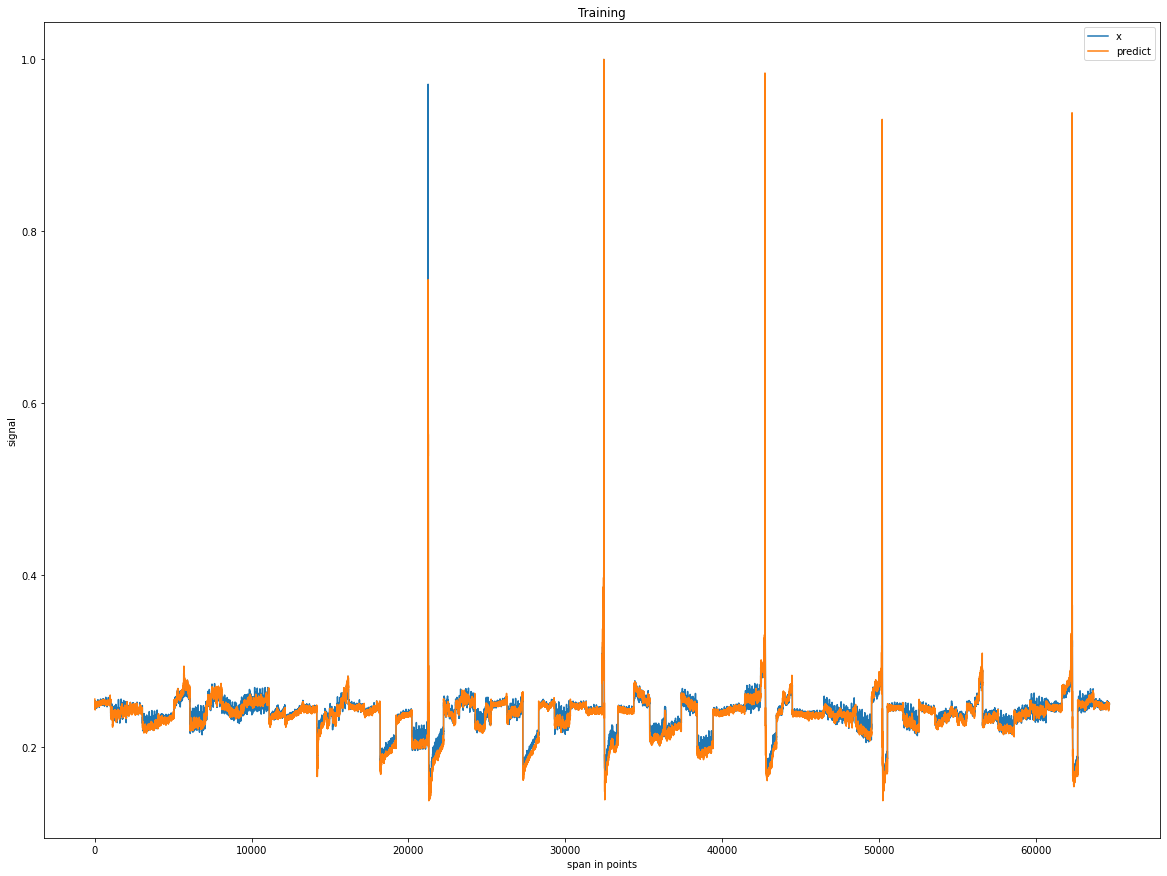

In [ ]:
dataiter = iter(myDataLoad.train_dataloader())
x, _ = dataiter.next()
x = x.to(modelED.device)
pedict = modelED(x)

x = np.ravel(x.cpu().numpy())
pedict = np.ravel(pedict.cpu().detach().numpy())
l=np.array(range(len(x))) #linspace(0, len(x), 1) 

plt.figure(figsize=(20, 15))
plt.plot(l, x, label="x")

plt.plot(l, pedict, label="predict")
plt.plot()

plt.xlabel("span in points")
plt.ylabel("signal")
plt.title("Training")
plt.legend()
plt.show()

In [ ]:
myDataLoad = None
trainerED = None

gc.collect()
torch.cuda.empty_cache()


In [ ]:
enco = Encoder(param_init=False)
enco.load_state_dict(torch.load(PATH_E))

deco = Decoder(param_init=False)
deco.load_state_dict(torch.load(PATH_D))

for param in enco.parameters():
    if param.requires_grad:
      param.requires_grad = False

for param in deco.parameters():
    if param.requires_grad:
      param.requires_grad = False

In [ ]:
class LSTMNeuroPredict(pl.LightningModule):
 
    def __init__(self, Encoder, Decoder, out_channels, kernel_size, input_size, hidden_size, num_layers, output_size, batch_size, learning_rate=0.001):
      super().__init__()

      def init_hidden():
        hidden = torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(self.device)
        cell = torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(self.device)
        return (hidden, cell)

      # Hyperparameters
      self.learning_rate = learning_rate
      self.batch_size = batch_size
      self.out_channels = out_channels
      self.kernel_size = kernel_size

      # Log hyperparameters
      self.save_hyperparameters()

      # Built-in API for Variance
      self.train_ExplainedVariance = pl.metrics.ExplainedVariance()
      self.val_ExplainedVariance = pl.metrics.ExplainedVariance()
      self.test_ExplainedVariance = pl.metrics.ExplainedVariance()

      #*****************************Model**************************************I
      self.hidden_size = hidden_size #The number of features in the hidden state h
      self.input_size = input_size #The number of expected features in the input x
      self.output_size = output_size
      self.num_layers = num_layers

      self.Ecoder = Encoder
      self.Decoder = Decoder

      for param in self.Ecoder.parameters():
        if param.requires_grad:
          param.requires_grad = False

      for param in self.Decoder.parameters():
        if param.requires_grad:
          param.requires_grad = False

      self.linear = nn.Linear(self.hidden_size, self.input_size)
      self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)

      self.hidden_cell = (torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(self.device),
                          torch.zeros(self.num_layers,self.batch_size,self.hidden_size).to(self.device)) #init_hidden() .to(self.device)
     # -------------------------------------------------------------------------            
    def forward(self, x, hs): #input of shape (batch,seq_len,1)
      #print('input x', x.shape)
      (H, C) = hs
      if H.shape[1] != self.batch_size:
        hs = (torch.zeros(self.num_layers,self.batch_size,self.hidden_size),
                            torch.zeros(self.num_layers,self.batch_size,self.hidden_size)) #init_hidden() .to(self.device)
      else:
        hs = (H.to(self.device), C.to(self.device))
      #print('hs ', hs[0].shape)
      x = self.Ecoder(x.permute(0,2,1)) #input of shape (batch,seq_len,1)->permute->(batch, feature=1, seq_len=1020)->out (batch, feature=8, seq_len=60)
      #print('self.Ecoder', x.shape)
      x = x.permute(0,2,1)
      #print('X convo out permute', x.shape)
      lstm_out, (H, C) = self.lstm(x, hs)                                #output of shape (batch,seq_len,hidden_size)
      #print('LSTM out ', lstm_out.shape)
      predictions = self.linear(lstm_out)  #output of shape (batch,seq_len, ch = 8)
      #print('self.linear ', predictions.shape)
      predictions = self.Decoder(predictions.permute(0,2,1)) #input (batch,seq_len, ch = 8)-> permute -> (batch,ch = 8, seq_len=60) -> out(batch,ch = 1, seq_len=1011)
      #print('predictions ', predictions.shape)
      predictions = predictions.permute(0,2,1) # (batch,seq_len,1)
      #print('predictions  permute', predictions)
      
      return predictions, (H, C)  # (H.to(self.device), C.to(self.device))
    # -------------------------------------------------------------------------
 
    def training_step(self, batch, batch_idx):
      x, y = batch
      HC = tuple([h.detach() for h in self.hidden_cell])
      # Feed the model and catch the prediction
      forecast, HC = self.forward(x, HC)

      H = HC[0].detach().to(self.device)  
      C = HC[1].detach().to(self.device)
      self.hidden_cell = (H, C) 
      
      #print(x.shape, y.shape, forecast.shape)
      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, y)
      # Calculates ExplainedVariance for current batch
      train_EV_batch = self.train_ExplainedVariance(forecast, y)
      # Save metrics for current batch
      self.log('train_EV_batch', train_EV_batch)
      self.log('train_loss_batch', loss)

      del H, C, HC#, forecast
      torch.cuda.empty_cache()

      return {'loss' : loss, 'forecast' : forecast, 'y_true' : y}
        
    def training_epoch_end(self, outputs):
      Train_ExplainedVariance = self.train_ExplainedVariance.compute()
      self.log('Train_EV_epoch', Train_ExplainedVariance, prog_bar=True)
      trainer.save_checkpoint(lastpath)
      gc.collect()

    # --------------------------------------------------------------------------
 
    def validation_step(self, batch, batch_idx):
      x, y = batch
      HC = tuple([h.detach() for h in self.hidden_cell])
      # Feed the model and catch the prediction
      forecast, HC = self.forward(x, HC)

      H = HC[0].detach().to(self.device)  
      C = HC[1].detach().to(self.device)
      self.hidden_cell = (H, C) 

      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, y)
      # Calculates ExplainedVariance for the current batch
      val_EV_batch = self.val_ExplainedVariance(forecast, y)
      # Save metrics for current batch
      self.log('val_EV_batch', val_EV_batch, prog_bar=False)
      self.log('val_loss_batch', loss, prog_bar=False)

      del H, C, HC#, forecast
      torch.cuda.empty_cache()

      return {'loss' : loss, 'forecast' : forecast, 'y_true' : y}
 
    def validation_epoch_end(self, outputs):
      Val_ExplainedVariance = self.val_ExplainedVariance.compute()
      self.log('val_EV_epoch', Val_ExplainedVariance, prog_bar=True)
      gc.collect()
    # --------------------------------------------------------------------------
 
    def test_step(self, batch, batch_idx):
      x, y = batch
      HC = tuple([h.detach() for h in self.hidden_cell])
      # Feed the model and catch the prediction
      forecast, HC = self.forward(x, HC)

      H = HC[0].detach().to(self.device)  
      C = HC[1].detach().to(self.device)
      self.hidden_cell = (H, C) 

      # Calculates loss for the current batch
      loss = F.mse_loss(forecast, y)
      # Calculates ExplainedVariance for the current batch
      test_EV_batch = self.test_ExplainedVariance(forecast, y)
      # Save metrics for current batch
      self.log('test_EV_batch', test_EV_batch, prog_bar=True)
      self.log('test_loss_batch', loss, prog_bar=True)
      self.logger.experiment.log_metric('test_EV_batch_', test_EV_batch)
      self.logger.experiment.log_metric('test_loss_batch_', loss)

    def test_epoch_end(self, outputs):
      Test_ExplainedVariance = self.test_ExplainedVariance.compute()
      self.log('Test_EV_epoch', Test_ExplainedVariance, prog_bar=False)
      self.logger.experiment.log_metric('Test_EV_epoch_', Test_ExplainedVariance)
      gc.collect()
    # --------------------------------------------------------------------------
 
    def configure_optimizers(self):
      optimizer =torch.optim.Adam(self.parameters(), lr=self.learning_rate, amsgrad=True)
      return optimizer

In [ ]:
# using datetime module
import datetime;
  
# ct stores current time
ct = datetime.datetime.now()
stamp = str(ct)[0:10]+'_'+str(ct)[11:16]
print("current time:-", ct) #.format(stamp)
checkpoint_callback = ModelCheckpoint(monitor='val_loss_batch',
                                      dirpath='/content/gdrive/PUT_YOUR_FOLDER/',
                                      filename='GapFreeLSTM_EncoDeco_L1out25-epoch{epoch:02d}-val_loss{val/loss:.2f}-val_EV_epoch{val_EV_epoch:.2f}-Train_EV_epoch{Train_EV_epoch:.2f}',
                                      save_last = True)#,
                                      #auto_insert_metric_name=False)

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)


# ******************************Initialize trainer for training*********************************************
trainer = pl.Trainer(max_epochs=PARAMS['m_max_epochs'],
                     min_epochs=5,
                     accumulate_grad_batches=4, 
                     check_val_every_n_epoch=19,
                     #num_sanity_val_steps=-1, 
                     precision=16,
                     gradient_clip_val=2.0,
                     callbacks = [early_stop_callback, checkpoint_callback],
                     log_gpu_memory=True,
                     profiler="simple",
                     progress_bar_refresh_rate=50,
                     logger=neptune_logger, 
                     auto_select_gpus=True, gpus=-1) #callbacks=[checkpoint_callback],

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


current time:- 2021-04-09 22:09:46.842799


In [ ]:
#Initiate the DataModule
myDataLoad = GapFreeDataModule(batch_size=PARAMS['batch_size'],
                               data_file_path = '/content/gdrive/PUT_YOUR_FOLDER/finaldata.csv', 
                               lookback = PARAMS['lookback'], 
                               lookforward = PARAMS['lookforward'])
myDataLoad.prepare_data()
myDataLoad.setup()
print(" Train Dataloader length = ", len(myDataLoad.train_dataloader()))

 Train Dataloader length =  3136


In [ ]:

model = LSTMNeuroPredict(Encoder = enco, Decoder = deco, 
                         out_channels=PARAMS['out_channels'], kernel_size=PARAMS['kernel_size'], input_size=PARAMS['input_size'],
                         hidden_size=PARAMS['hidden_size'], num_layers=PARAMS['num_layers'], output_size=PARAMS['output_size'], 
                         learning_rate=PARAMS['learning_rate'], batch_size=PARAMS['batch_size'])


In [ ]:
trainer.fit(model, myDataLoad)

In [ ]:
#model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_callback.best_model_path)
#model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_path=lastpath)


In [ ]:
for param in model.Ecoder.parameters():
        if param.requires_grad:
          print("Enco is Gradding")
        else:
          param.requires_grad = True

for param in model.Decoder.parameters():
        if param.requires_grad:
          print("Enco is Gradding")
        else:
          param.requires_grad = True

In [ ]:
# Train for LSTMNeuroPredict
max_iter = m_max_epochs
iter_n = 0
#model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_path=lastpath)

def ErrorHandle_1(model = model, DataLoad = myDataLoad, trainer = trainer, iter=0, max_iter = max_iter):
  print("current iteration = ", iter)
  print(torch.cuda.max_memory_allocated())
  torch.cuda.empty_cache()
  print(torch.cuda.max_memory_allocated())
  print(iter)
  if iter==0:
    try:
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_2(model = None, iter = iter, max_iter = max_iter)
  elif iter > max_iter:
    return
  else:
    try:
      model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_path=lastpath)#(checkpoint_callback.best_model_path)
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_2(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)
    
def ErrorHandle_2(model = model, DataLoad = myDataLoad, trainer = trainer, iter=iter_n, max_iter = max_iter):
  print("current iteration = ", iter)
  print(torch.cuda.max_memory_allocated())
  torch.cuda.empty_cache()
  print(torch.cuda.max_memory_allocated())
  if iter==0:
    try:
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_1(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)
  elif iter > max_iter:
    return
  else:
    try:
      model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_path=lastpath)#(checkpoint_callback.best_model_path)
      trainer.fit(model, DataLoad)
    except OverflowError:  
      print("OverFlow Exception Raised. Saving the model")
      print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
      print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
      print(torch.cuda.memory_summary(device=None, abbreviated=False))
      pass
    else:  
      print ("Success, no error!")
      print("checkpoint_callback", checkpoint_callback.best_model_score)
      print("checkpoint_best_model_path", checkpoint_callback.best_model_path)
    finally:
      model = None
      gc.collect()
      torch.cuda.empty_cache()
      iter+=1
      ErrorHandle_1(model = model, DataLoad = myDataLoad, iter = iter, max_iter = max_iter)

try:
  ErrorHandle_1(model = model, DataLoad = myDataLoad, trainer = trainer, iter=iter_n, max_iter = max_iter)
except:
  print("trained as much as it could")
  pass
finally:
  model = None
  gc.collect()
  torch.cuda.empty_cache()
  model = LSTMNeuroPredict.load_from_checkpoint(checkpoint_path=lastpath)

  # Test
  trainer.test(model,datamodule=myDataLoad)

  #stopt the Neptune logger
  #neptune_logger.experiment.stop()




LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  0
221184
221184
0
https://app.neptune.ai/sergiirom/GapFreeLSTM/e/GAP-34



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


Saving latest checkpoint...




Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  218.33         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  47.258         	|4              	|  189.03         	|  86.581         	|
run_training_batch                 	|  0.012998       	|12544          	|  163.04         	|  74.678         	|
training_step_and_backward         	|  0.012425       	|12544          	|  155.86         	|  71.39          	|
model_forward                      	|  0.0084674      	|12544          	|  106.21         	|  48.649         	|
training_step                      	|  0.

current iteration =  1
14618494976
14618494976



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  2
14618494976
14618494976
2



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  3
15032590848
15032590848



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  4
15291869696
15291869696
4



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  5
15291869696
15291869696



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  6
15293327360
15293327360
6



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



current iteration =  7
15302864384
15302864384



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  8
15304012800
15304012800
8



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  9
15305161728
15305161728



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  10
15306310656
15306310656
10



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  11
15307459584
15307459584



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  12
15308608512
15308608512
12



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  13
15309757440
15309757440



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  14
15310906368
15310906368
14



  | Name                    | Type              | Params
--------------------------------------------------------------
0 | train_ExplainedVariance | ExplainedVariance | 0     
1 | Ecoder                  | Encoder           | 19.6 K
2 | Decoder                 | Decoder           | 52.0 K
3 | linear                  | Linear            | 284   
4 | lstm                    | LSTM              | 61.0 K
--------------------------------------------------------------
61.3 K    Trainable params
71.6 K    Non-trainable params
132 K     Total params
0.532     Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  15
15312055296
15312055296


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  16
15312058368
15312058368
16


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  17
15312193024
15312193024


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  18
15312327680
15312327680
18


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  19
15312462336
15312462336


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


current iteration =  20
15312596992
15312596992
20
current iteration =  21
15312731648
15312731648
trained as much as it could


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_EV_epoch': 0.7756353616714478,
 'test_EV_batch': 0.7840792536735535,
 'test_loss_batch': 0.00021588130039162934}
--------------------------------------------------------------------------------


In [ ]:
print("SoFar_checkpoint_callback", checkpoint_callback.best_model_score)
print("SoFar_checkpoint_best_model_path", checkpoint_callback.best_model_path)
print(torch.cuda.max_memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated())
#del model
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated())


SoFar_checkpoint_callback tensor(0.0013, device='cuda:0')
SoFar_checkpoint_best_model_path /content/gdrive/MyDrive/Data_AI/GapFreeLSTM_EncoDeco_L1out25-epochepoch=03-val_lossval/loss=0.00-val_EV_epochval_EV_epoch=0.00-Train_EV_epochTrain_EV_epoch=0.57.ckpt
15312731648
15312731648
15312731648
15312731648
